앞선 Baseline에서 가장 낮은 RMSLE를 보였던 랜덤 포레스트 모델을 기준으로 EDA를 통해 보았던 season과 hour 등의 범주형 변수의 정보를 제대로 활용하고자 원-핫 인코딩을 진행하여 모델을 적합시켜본다. 또한 year 변수도 추가한다.
  
또한 모델 훈련 시 validation set도 만들어 보다 일반화가 가능하도록 모델을 적합시킨다.

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
sns.set(font_scale=2.5)

import missingno as msno
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import calendar

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df = train.copy()
test_df = test.copy()
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [11]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

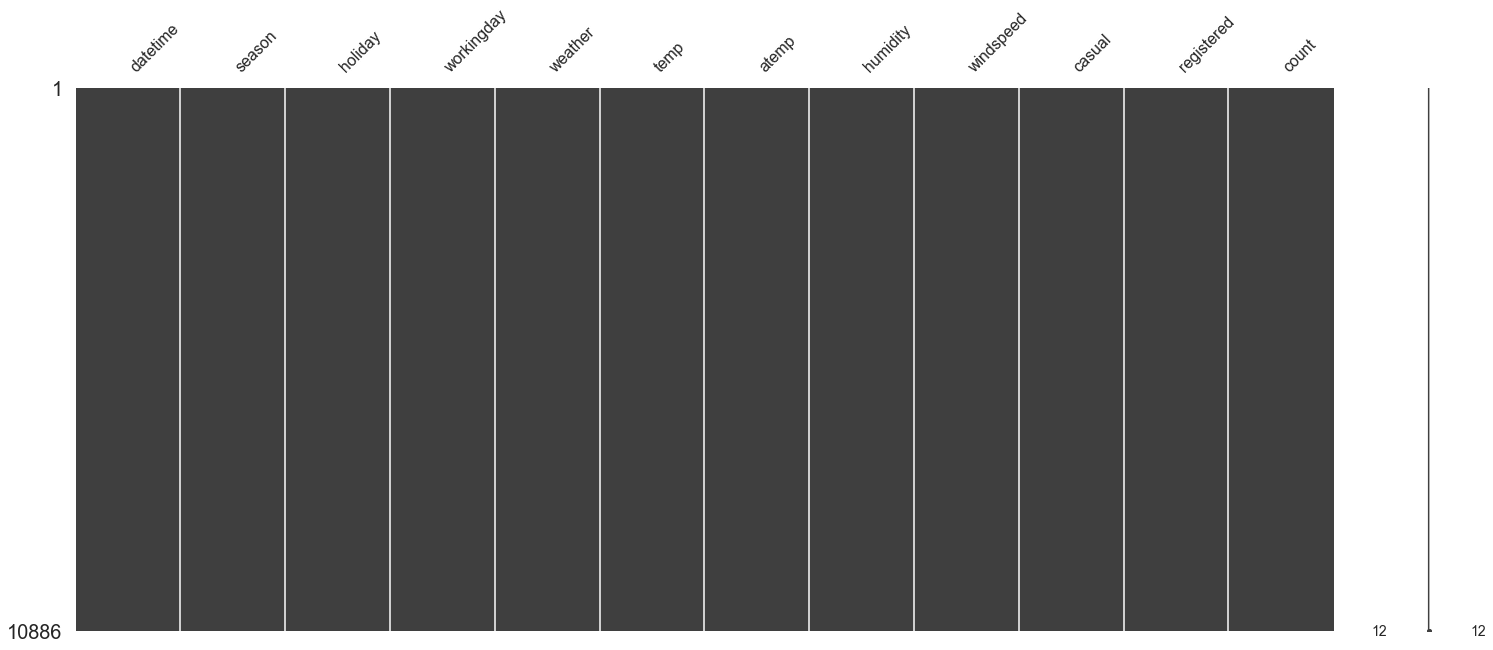

In [12]:
msno.matrix(df)

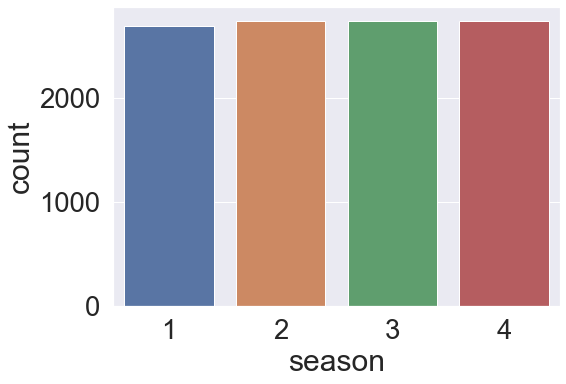

In [14]:
sns.countplot(x='season', data=df)

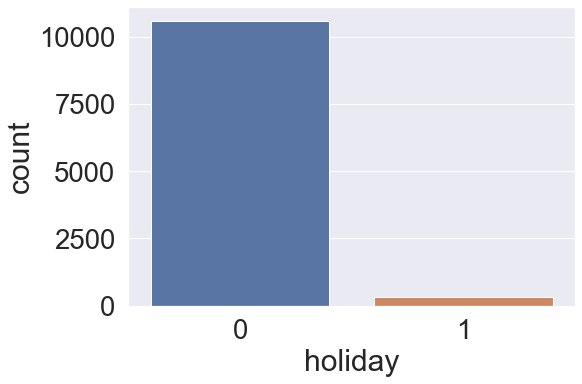

In [15]:
sns.countplot(x='holiday', data=df)

In [4]:
train['date'] = train['datetime'].apply(lambda x: x.split()[0])
train['hour'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[0])
train['year'] = train['date'].apply(lambda x: x.split('-')[0])
train['weekday'] = train['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d').weekday())
train['month'] = train['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d').month)


In [5]:
test['date'] = test['datetime'].apply(lambda x: x.split()[0])
test['hour'] = test['datetime'].apply(lambda x: x.split()[1].split(':')[0])
test['year'] = test['date'].apply(lambda x: x.split('-')[0])
test['weekday'] = test['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d').weekday())
test['month'] = test['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d').month)


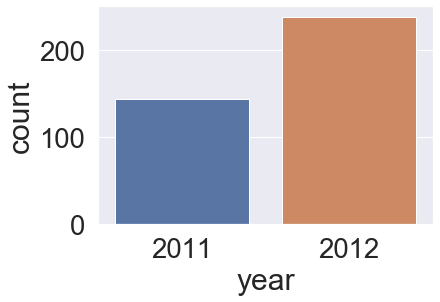

In [6]:
df_year = pd.DataFrame(train.groupby('year')['count'].mean()).reset_index()
sns.barplot(x=df_year['year'], y=df_year['count'])

In [7]:
train['year'] = train['year'].astype('int').map({2011:0, 2012:1})
test['year'] = test['year'].astype('int').map({2011:0, 2012:1})

### Random Forest Model To Predict 0's In Windspeed

In [8]:
data = train.append(test)
data.reset_index(inplace=True)
data.drop('index', axis=1, inplace=True)

In [9]:
from sklearn.ensemble import RandomForestRegressor

dataWind0 = data[data['windspeed'] == 0]
dataWindNot0 = data[data['windspeed'] != 0]

rf_wind = RandomForestRegressor()

# 풍속에 영향을 주는 column들만 모아둔 리스트
windColumns = ['season', 'weather', 'humidity', 'month', 'temp', 'year', 'atemp']

# windwpeed가 0이 아닌 데이터셋을 이용해 랜덤 포레스트 모델 학습
rf_wind.fit(dataWindNot0[windColumns], dataWindNot0['windspeed'])

# windspeed가 0인 데이터 포인트의 windspeed 예측
wind0Values = rf_wind.predict(X = dataWind0[windColumns])

dataWind0['windspeed'] = wind0Values
data = dataWindNot0.append(dataWind0)
data.reset_index(inplace=True)
data.drop('index', axis=1, inplace=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
atemp         17379 non-null float64
casual        10886 non-null float64
count         10886 non-null float64
date          17379 non-null object
datetime      17379 non-null object
holiday       17379 non-null int64
hour          17379 non-null object
humidity      17379 non-null int64
month         17379 non-null int64
registered    10886 non-null float64
season        17379 non-null int64
temp          17379 non-null float64
weather       17379 non-null int64
weekday       17379 non-null int64
windspeed     17379 non-null float64
workingday    17379 non-null int64
year          17379 non-null int64
dtypes: float64(6), int64(8), object(3)
memory usage: 2.3+ MB


In [11]:
categoricalFeatureNames = ['season', 'holiday', 'weather', 'workingday','weekday', 'month', 'year','hour']
numericalFeatureNames = ['atemp','humidity','temp','windspeed']
dropFeatures = ['casual','datetime','registered','count','date']

In [12]:
for var in categoricalFeatureNames:
    data[var] = data[var].astype('category')

In [13]:
train = data[pd.notnull(data['count'])].sort_values(by='datetime')
test = data[pd.isnull(data['count'])].sort_values(by='datetime')
datetimecol = test['datetime']
y_labels = train['count']
y_registered = train['registered']
y_casual = train['casual']

In [14]:
train = train.drop(dropFeatures, axis=1)
test = test.drop(dropFeatures, axis=1)

## One-Hot Encoding

In [15]:
season = pd.get_dummies(train['season'], prefix = 'season')
train = pd.concat([train, season], axis=1)
train.head()

,atemp,holiday,hour,humidity,month,season,temp,weather,weekday,windspeed,workingday,year,season_1,season_2,season_3,season_4
15199,14.395,0,00,81,1,1,9.84,1,5,6.960407,0,0,1,0,0,0
15200,13.635,0,01,80,1,1,9.02,1,5,6.727369,0,0,1,0,0,0
15201,13.635,0,02,80,1,1,9.02,1,5,6.727369,0,0,1,0,0,0
15202,14.395,0,03,75,1,1,9.84,1,5,6.587205,0,0,1,0,0,0
15203,14.395,0,04,75,1,1,9.84,1,5,6.587205,0,0,1,0,0,0


In [16]:
season = pd.get_dummies(test['season'], prefix = 'season')
test = pd.concat([test, season], axis=1)
test.head()

,atemp,holiday,hour,humidity,month,season,temp,weather,weekday,windspeed,workingday,year,season_1,season_2,season_3,season_4
9573,11.365,0,00,56,1,1,10.66,1,3,26.002700,1,0,1,0,0,0
16512,13.635,0,01,56,1,1,10.66,1,3,8.830952,1,0,1,0,0,0
16513,13.635,0,02,56,1,1,10.66,1,3,8.830952,1,0,1,0,0,0
9574,12.880,0,03,56,1,1,10.66,1,3,11.001400,1,0,1,0,0,0
9575,12.880,0,04,56,1,1,10.66,1,3,11.001400,1,0,1,0,0,0


In [17]:
weather = pd.get_dummies(train['weather'], prefix = 'weather')
train = pd.concat([train, weather], axis=1)
train.head()

,atemp,holiday,hour,humidity,month,season,temp,weather,weekday,windspeed,workingday,year,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
15199,14.395,0,00,81,1,1,9.84,1,5,6.960407,0,0,1,0,0,0,1,0,0,0
15200,13.635,0,01,80,1,1,9.02,1,5,6.727369,0,0,1,0,0,0,1,0,0,0
15201,13.635,0,02,80,1,1,9.02,1,5,6.727369,0,0,1,0,0,0,1,0,0,0
15202,14.395,0,03,75,1,1,9.84,1,5,6.587205,0,0,1,0,0,0,1,0,0,0
15203,14.395,0,04,75,1,1,9.84,1,5,6.587205,0,0,1,0,0,0,1,0,0,0


In [18]:
weather = pd.get_dummies(test['weather'], prefix = 'weather')
test = pd.concat([test, weather], axis=1)
test.head()

,atemp,holiday,hour,humidity,month,season,temp,weather,weekday,windspeed,workingday,year,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
9573,11.365,0,00,56,1,1,10.66,1,3,26.002700,1,0,1,0,0,0,1,0,0,0
16512,13.635,0,01,56,1,1,10.66,1,3,8.830952,1,0,1,0,0,0,1,0,0,0
16513,13.635,0,02,56,1,1,10.66,1,3,8.830952,1,0,1,0,0,0,1,0,0,0
9574,12.880,0,03,56,1,1,10.66,1,3,11.001400,1,0,1,0,0,0,1,0,0,0
9575,12.880,0,04,56,1,1,10.66,1,3,11.001400,1,0,1,0,0,0,1,0,0,0


In [19]:
train.drop(['season','weather'], inplace=True, axis=1)
test.drop(['season','weather'], inplace=True, axis=1)

In [20]:
train.head()

,atemp,holiday,hour,humidity,month,temp,weekday,windspeed,workingday,year,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
15199,14.395,0,00,81,1,9.84,5,6.960407,0,0,1,0,0,0,1,0,0,0
15200,13.635,0,01,80,1,9.02,5,6.727369,0,0,1,0,0,0,1,0,0,0
15201,13.635,0,02,80,1,9.02,5,6.727369,0,0,1,0,0,0,1,0,0,0
15202,14.395,0,03,75,1,9.84,5,6.587205,0,0,1,0,0,0,1,0,0,0
15203,14.395,0,04,75,1,9.84,5,6.587205,0,0,1,0,0,0,1,0,0,0


In [21]:
test.head()

,atemp,holiday,hour,humidity,month,temp,weekday,windspeed,workingday,year,season_1,season_2,season_3,season_4,weather_1,weather_2,weather_3,weather_4
9573,11.365,0,00,56,1,10.66,3,26.002700,1,0,1,0,0,0,1,0,0,0
16512,13.635,0,01,56,1,10.66,3,8.830952,1,0,1,0,0,0,1,0,0,0
16513,13.635,0,02,56,1,10.66,3,8.830952,1,0,1,0,0,0,1,0,0,0
9574,12.880,0,03,56,1,10.66,3,11.001400,1,0,1,0,0,0,1,0,0,0
9575,12.880,0,04,56,1,10.66,3,11.001400,1,0,1,0,0,0,1,0,0,0


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10886 entries, 15199 to 9572
Data columns (total 18 columns):
atemp         10886 non-null float64
holiday       10886 non-null category
hour          10886 non-null category
humidity      10886 non-null int64
month         10886 non-null category
temp          10886 non-null float64
weekday       10886 non-null category
windspeed     10886 non-null float64
workingday    10886 non-null category
year          10886 non-null category
season_1      10886 non-null uint8
season_2      10886 non-null uint8
season_3      10886 non-null uint8
season_4      10886 non-null uint8
weather_1     10886 non-null uint8
weather_2     10886 non-null uint8
weather_3     10886 non-null uint8
weather_4     10886 non-null uint8
dtypes: category(6), float64(3), int64(1), uint8(8)
memory usage: 575.9 KB


## RMSLE Scorer

In [23]:
def rmsle(y_pred, y_true, convertExp=True):
    if convertExp:
        y_pred = np.exp(y_pred)
        y_true = np.exp(y_true)
           
    # 예측값과 실제값에 1을 더하고 로그를 씌워준다.
    # np.nan_to_num 함수는 NaN을 0으로, inf값은 매우 큰 정수값으로 반환해줌
    log1 = np.nan_to_num(np.array([np.log(x + 1) for x in y_pred]))
    log2 = np.nan_to_num(np.array([np.log(x + 1) for x in y_true]))  
    
    # 위에서 계산한 예측값에서 실제값을 빼고 제곱을 해준다.
    cal = (log1 - log2) ** 2
    
    # 평균의 제곱을 반환한다.
    return np.sqrt(np.mean(cal))

# Model

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, y_labels, test_size=0.25, random_state=42)

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

In [122]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_jobs=-1)
forest_params = {'n_estimators':[500], 'max_features':['auto','sqrt','log2']}

scorer = metrics.make_scorer(rmsle, greater_is_better=False)

grid_forest = GridSearchCV(forest,
                          forest_params,
                          scoring=scorer)

In [125]:
y_trainlog = np.log(y_train)

grid_forest.fit(X_train, y_trainlog)
preds = grid_forest.predict(X_test)
print('RMSLE For Validation Set: {}'.format(rmsle(np.exp(preds), y_test, False)))

RMSLE For Validation Set: 0.293063846866736


In [126]:
grid_forest.best_params_

{'max_features': 'auto', 'n_estimators': 500}

### train all data and predict test set

In [127]:
y_labelslog = np.log(y_labels)
forest = RandomForestRegressor(n_jobs=-1, n_estimators=500 , max_features='auto')
forest.fit(train, y_labelslog)

predtest = forest.predict(test)

In [128]:
submission = pd.read_csv('sampleSubmission.csv')
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [129]:
submission['count'] = [max(0,x) for x in np.exp(predtest)]
submission.head()

,datetime,count
0,2011-01-20 00:00:00,10.452069
1,2011-01-20 01:00:00,4.821120
2,2011-01-20 02:00:00,2.857269
3,2011-01-20 03:00:00,3.051002
4,2011-01-20 04:00:00,2.592682


In [130]:
submission.to_csv('my_bike_prediction.csv', index=False)

## Gradient Boost

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(n_estimators=4000, alpha=0.01, random_state=12)
y_labelslog = np.log(y_labels)
gbm.fit(train, y_labelslog)
preds = gbm.predict(train)
print('RMSLE Value For Gradient Boost: {}'.format(rmsle(np.exp(preds), np.exp(y_labelslog), False)))
predtest = gbm.predict(test)

RMSLE Value For Gradient Boost: 0.20031527954171993


In [27]:
submission = pd.read_csv('sampleSubmission.csv')
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [28]:
submission['count'] = [max(0,x) for x in np.exp(predtest)]
submission.head()

,datetime,count
0,2011-01-20 00:00:00,9.209040
1,2011-01-20 01:00:00,5.129872
2,2011-01-20 02:00:00,3.052053
3,2011-01-20 03:00:00,1.841795
4,2011-01-20 04:00:00,1.421875


In [29]:
submission.to_csv('my_bike_prediction2.csv', index=False)